### Download the data

In [1]:
!wget https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv

--2022-08-12 20:11:01--  https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5998096 (5.7M) [text/plain]
Saving to: ‘AE_Data.csv’

AE_Data.csv         100%[===================>]   5.72M  --.-KB/s    in 0.1s    

2022-08-12 20:11:02 (58.2 MB/s) - ‘AE_Data.csv’ saved [5998096/5998096]



### Import libraries

In [2]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv('/content/AE_Data.csv')
df.head()

,title,abstract,label
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0


In [4]:
df['label'].value_counts()

0    3851
1     294
Name: label, dtype: int64

This is unbalanced classification!

### Word Count in Abstract and Title

In [9]:
df['word_count_abstract'] = df['abstract'].str.split().str.len()
df['word_count_title'] = df['title'].str.split().str.len()

print('Min word count in Abstract : ', df['word_count_abstract'].min())
print('Max word count in Abstract : ', df['word_count_abstract'].max())
print('Min word count in Title : ', df['word_count_title'].min())
print('Max word count in Title : ', df['word_count_title'].max())

Min word count in Abstract :  0
Max word count in Abstract :  938
Min word count in Title :  1
Max word count in Title :  35


In [15]:
abstract_bins = range(0,1000,200)

title_bins = range(0,35,7)

# We can use the same iterator for bin and label
df['binned_abstract'] = pd.cut(df['word_count_abstract'], bins=abstract_bins, labels = abstract_bins[1:])
df['binned_title'] = pd.cut(df['word_count_title'], bins=title_bins, labels = title_bins[1:])

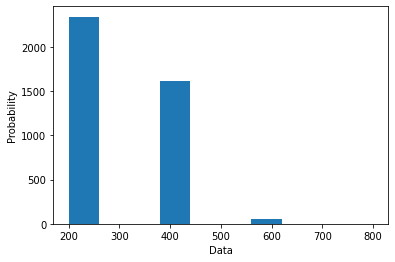

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# np.random.seed(42)
# x = np.random.normal(size=1000)

plt.hist(df['binned_abstract'], density=False)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');